# Eluvio Code Challenge

Aman Dhar

10/21/19

Exploratory Data Analysis on Reddit r/worldnews Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("Eluvio_DS_Challenge.csv")
data.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


First, we see below that the `category` is 'worldnews' for all entries in the dataset, and `down_votes` is always 0. We can likely ignore these columns in our analysis.

There are over 85000 different authors in this dataset, and the data spans over 8 years.

In [3]:
print(data["category"].unique())
print(data["author"].unique(), len(data["author"].unique()))
print(data["down_votes"].unique())
print(data["date_created"].min(), data["date_created"].max())

['worldnews']
['polar' 'fadi420' 'mhermans' ..., 'calfellow' 'Randiathrowaway1'
 'SummerRay'] 85838
[0]
2008-01-25 2016-11-22


Let's make columns for the timestamps so they are easier to deal with:

In [4]:
data["datetime"] = pd.to_datetime(data["time_created"], unit='s')
data["hour"] = data["datetime"].dt.hour

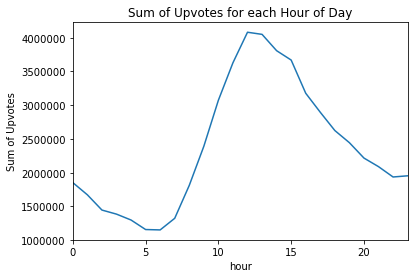

In [5]:
votes_over_hours_df = data.groupby("hour")["up_votes"].sum()
votes_over_hours_df.plot()
plt.title("Sum of Upvotes for each Hour of Day")
plt.ylabel("Sum of Upvotes");

Here, we see that most of the upvotes recorded come from posts that were created between hours 10 and 15. However, this could be due to the fact that more posts are created around that time. Let's also look at the average upvotes per hour.

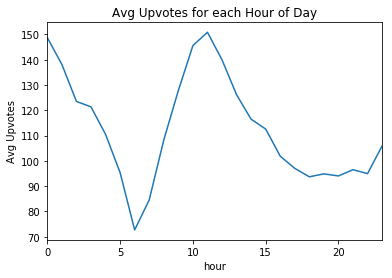

In [6]:
votes_over_hours_df = data.groupby("hour")["up_votes"].mean()
votes_over_hours_df.plot()
plt.title("Avg Upvotes for each Hour of Day")
plt.ylabel("Avg Upvotes");

There is still a peak around hour 11, but a new one appears around midnight.

0.09860850371929715


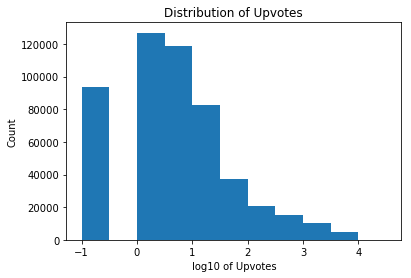

In [7]:
plt.hist(np.log10(data["up_votes"] + 0.1), bins=np.arange(-1, 5, 0.5)) # adding 0.1 to avoid log(0) error
plt.title("Distribution of Upvotes")
plt.xlabel("log10 of Upvotes")
plt.ylabel("Count")
print(len(data[data["up_votes"] > 100]) / len(data)); 

The bar on the left shows posts with 0 upvotes. The distribution of upvotes is skew right (longer right tail). Given this, let's define a "popular" post to be one with 100 upvotes. This should give us only the top ~10% of posts to examine more in-depth. Let's also use the previous plots to look at posts at midnight and 11am.

In [8]:
# https://gist.githubusercontent.com/larsyencken/1440509/raw/53273c6c202b35ef00194d06751d8ef630e53df2/stopwords.txt
with open("stopwords.txt", "r") as f:
    stopwords = f.read().split("\n")[6:-1]

In [9]:
morning_subset = data[(data["hour"] == 11) & (data["up_votes"] > 100)]
midnight_subset = data[(data["hour"] == 0) & (data["up_votes"] > 100)]
midnight_subset.shape

(1542, 10)

In [10]:
def get_common_words_in_post_titles(df):
    unpacked_words = (df.title.str.lower()
                              .str.replace('[^\w\s]','') # remove punctuation
                              .str.split(expand=True)
                              .stack()
                              .reset_index()
                              .drop("level_1", axis=1)
                              .rename(columns={'level_0': 'index', 0: 'word'}))
    unpacked_words = pd.merge(unpacked_words, data[["up_votes"]], left_on="index", right_index=True)
    unpacked_words = unpacked_words.groupby("word")["up_votes"].agg(sum).sort_values(ascending=False)
    meaningful_words = [idx for idx in unpacked_words.index if idx not in stopwords]
    return unpacked_words[meaningful_words]

In [11]:
common_midnight_words = get_common_words_in_post_titles(midnight_subset)
common_morning_words = get_common_words_in_post_titles(morning_subset)
print("MIDNIGHT WORDS:\n", common_midnight_words[:20])
print("\n")
print("MORNING WORDS:\n",common_morning_words[:20])

MIDNIGHT WORDS:
 word
world         93102
people        86578
government    84653
isis          80022
china         67178
drug          64779
north         62572
korea         61255
un            57738
internet      56916
report        56759
police        56008
canada        55695
military      52830
found         50408
australia     50274
trade         46398
company       46214
court         44228
uk            44136
Name: up_votes, dtype: int64


MORNING WORDS:
 word
world         225026
people        189072
russia        163177
police        155262
china         148597
uk            120748
minister      115529
government    115238
isis          110145
president     100829
russian        95717
country        93773
killed         90567
korea          88820
turkey         87853
germany        86320
women          86085
north          84823
found          83576
ban            83044
Name: up_votes, dtype: int64


It appears that the timing of the posts may be related to the country names mentioned in the post title. In the morning subset, it looks like popular posts discuss Russia, China, UK, Korea, Turkey, and Germany. In the midnight subset, we see China, Korea, Canada, Australia, and UK. If a business wanted to spread world news to relevant users, they would need to consider posting at 12am or 11am depending on the region they are trying to target.

With a larger dataset that does not fit on RAM, we could take several samples of posts and perform the same exploratory data analysis on each sample. Using the top words/times generated by each sample, we could intelligently weight them to come up with a set of general guidelines for "when to post to which country/region."